In [1]:
from msdm.domains import GridWorld
from msdm.algorithms.entregpolicyiteration import entropy_regularized_policy_iteration
from msdm.core.problemclasses.mdp import TabularPolicy
from algorithms import ConstruedLikelihoodIRL, MaxLikelihoodIRL
import torch
from frozendict import frozendict
from dataset import TrajectoryDataset
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations

In [5]:
# hyperparameters
num_trajs = 10000
epochs = 10
batch_size = 128
lr = 1
weight_decay = 0
momentum = 0.9
entropy_weight = 3.9
discount_rate = 0.99

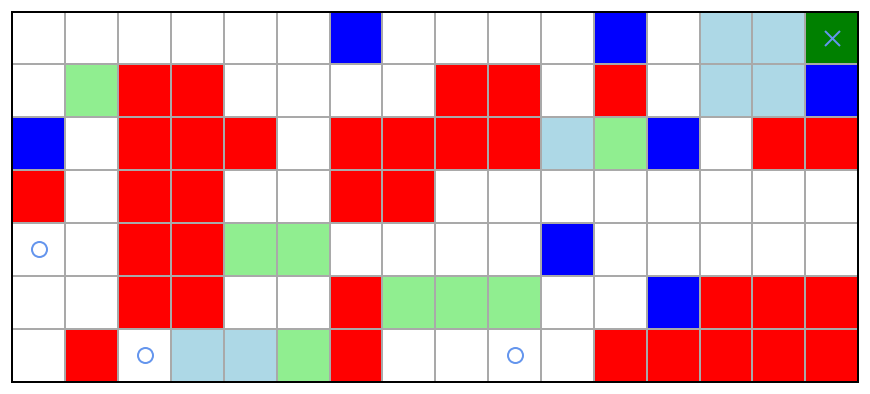

In [6]:
# Create a gridworld
mdp = GridWorld(
    tile_array=[
        "......c....c.bbg",
        ".axx....xx.x.bbc",
        "c.xxx.xxxxbac.xx",
        "x.xx..xx........",
        "s.xxaa....c.....",
        "..xx..xaaa..cxxx",
        ".xsbbax..s.xxxxx",
    ],
    feature_rewards={
        'g': 10,
        'x': -500,
        'c': -5,
        '.': 0,
        'a': 0,
        'b': 0,
    },
    absorbing_features=('g'),
    initial_features=('s'),
    discount_rate=discount_rate,
)
featurecolors = {
    'g': 'green',
    'x': 'red',
    'c': 'blue',
    '.': 'white',
    'a': 'lightgreen',
    'b': 'lightblue'
}
mdp.plot(featurecolors=featurecolors)


In [7]:
expert_erpi_params = dict(
    transition_matrix=torch.tensor(mdp.transition_matrix),
    reward_matrix=torch.tensor(mdp.reward_matrix),
    discount_rate=torch.tensor(mdp.discount_rate),
    # the lower this is, the more optimal the policy
    entropy_weight=torch.tensor([entropy_weight]),
    n_planning_iters=10,
    policy_prior=None,
    initial_policy=None,
    check_convergence=True,
    force_nonzero_probabilities=True,
)

# Max Entropy IRL expert policy
expert_erpi = entropy_regularized_policy_iteration(
    **expert_erpi_params
)

expert_policy = TabularPolicy.from_matrix(
    states=mdp.state_list,
    actions=mdp.action_list,
    policy_matrix=expert_erpi.policy.detach().numpy()
)


In [8]:
def featurizer(state, action, next_state):
  feature_name = mdp.location_features.get(next_state, 's')
  if feature_name in 's':
    return {}
  return {feature_name: 1}

def fixed_reward(state, action, next_state):
  return mdp.step_cost

In [9]:
construal_alg = ConstruedLikelihoodIRL(mdp, featurizer, fixed_reward, batch_size=batch_size, epochs=epochs, lr=lr, momentum=momentum, entropy_weight=entropy_weight, weight_decay=weight_decay)
max_alg = MaxLikelihoodIRL(mdp, featurizer, fixed_reward, batch_size=batch_size, epochs=epochs, lr=lr, momentum=momentum, entropy_weight=entropy_weight, weight_decay=weight_decay)

In [10]:
features = [f for f in sorted(mdp.feature_locations.keys()) if f not in 's']
# all n choose 2 feature pairs
all_feature_pairs = list(combinations(features, 2))
r_weights = torch.zeros(len(features))
for feature_name, reward in mdp._featureRewards.items():
  if feature_name != '.':
    r_weights[features.index(feature_name)] = reward

r_weights = r_weights.double()


In [11]:
num_construals = len(all_feature_pairs)
construed_policies = []
vor = torch.zeros(num_construals)
softmax_fn = torch.nn.Softmax(dim=0)

for feature_pair in all_feature_pairs:
    weight_mask = torch.zeros(len(features))
    for feature in feature_pair:
        weight_mask[features.index(feature)] = 1
    feature_reward_matrix = torch.einsum(
        "sanf,f->san",
        construal_alg.get_feature_matrix(),
        r_weights * weight_mask
    )
    reward_matrix = feature_reward_matrix + construal_alg.get_fixed_reward_matrix()
    terminal_index = mdp.state_index.get(
        frozendict({'x': -1, 'y': -1}))
    reward_matrix[:, :, terminal_index] = 0

    res = entropy_regularized_policy_iteration(torch.tensor(mdp.transition_matrix), reward_matrix, torch.tensor(mdp.discount_rate), entropy_weight=torch.tensor([entropy_weight]), n_planning_iters=10).policy
    policy = TabularPolicy.from_matrix(
        states=mdp.state_list,
        actions=mdp.action_list,
        policy_matrix=res.detach().numpy()
    )
    construed_policies.append(policy)
    vor[len(construed_policies)-1] = policy.evaluate_on(mdp).initial_value
# softmax distribution over the construals
softmax_vor = softmax_fn(vor).numpy()


In [12]:
rng = np.random.default_rng()

In [13]:
# Generate gen_iters of trajectories
gen_iters = num_trajs
trajectories = []

for _ in range(gen_iters):
  # sample a construed policy per trajectory according to the softmax distribution
  construed_pol = rng.choice(construed_policies, p=softmax_vor)
  trajectory = construed_pol.run_on(mdp)
  formatted_traj = {}
  formatted_traj['state_traj'] = trajectory.state_traj
  formatted_traj['action_traj'] = trajectory.action_traj
  trajectories.append(formatted_traj)

trajs_dataset = TrajectoryDataset(trajectories)


In [14]:
construal_learned_weights, construal_erpi, construal_losses = construal_alg.learn(trajs_dataset)
max_learned_weights, max_erpi, max_losses = max_alg.learn(trajs_dataset)

Using cuda
Inital reward weights: tensor([-0.1740, -1.9807, -0.5698,  0.2595, -0.6215], dtype=torch.float64)

loss: 0.551677  [    0/10000]
loss: 0.512227  [    0/10000]
loss: 0.503032  [    0/10000]
loss: 0.541833  [    0/10000]
loss: 0.540895  [    0/10000]
loss: 0.505610  [    0/10000]
loss: 0.508224  [    0/10000]


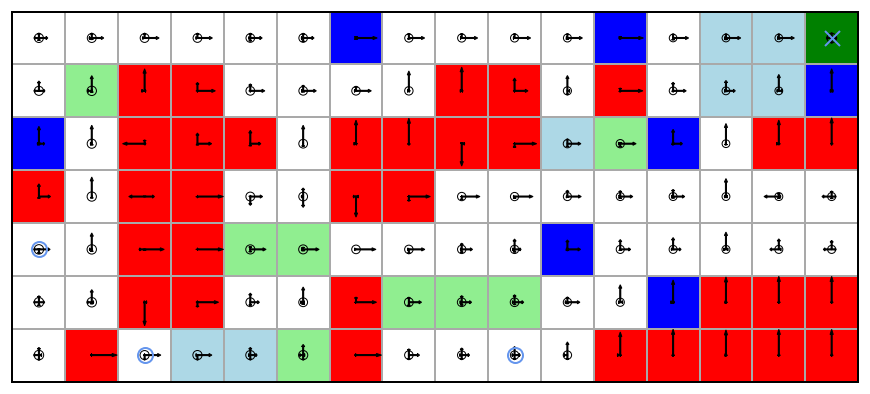

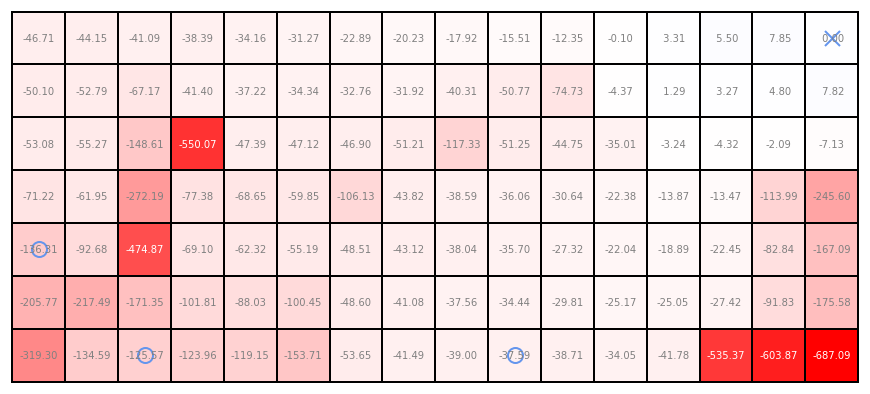

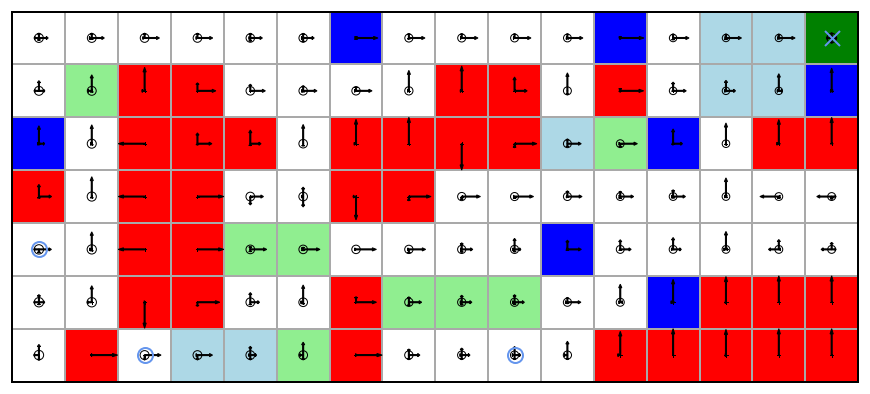

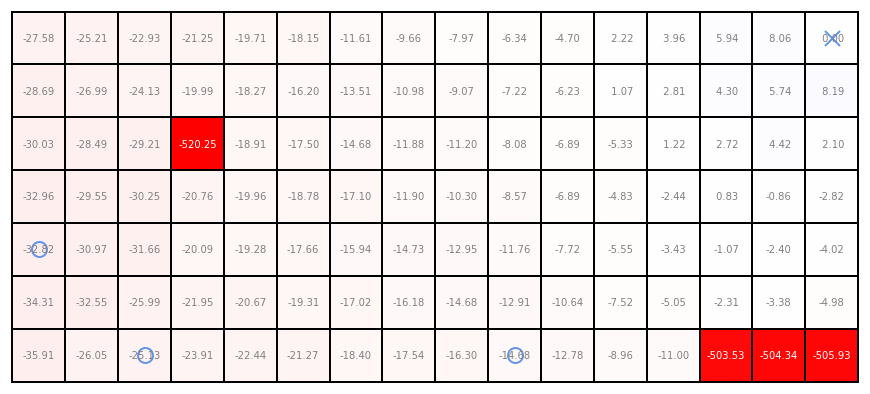

In [ ]:
# solve with matrices returned by gridworld object
construal_policy = TabularPolicy.from_matrix(
    states=mdp.state_list,
    actions=mdp.action_list,
    policy_matrix=construal_erpi.policy.detach().numpy()
)

max_policy = TabularPolicy.from_matrix(
    states=mdp.state_list,
    actions=mdp.action_list,
    policy_matrix=max_erpi.policy.detach().numpy()
)

mdp.plot(featurecolors=featurecolors).plot_policy(construal_policy)
mdp.plot().plot_state_map(construal_policy.evaluate_on(mdp).V)

mdp.plot(featurecolors=featurecolors).plot_policy(expert_policy)
mdp.plot().plot_state_map(expert_policy.evaluate_on(mdp).V)

mdp.plot(featurecolors=featurecolors).plot_policy(max_policy)
mdp.plot().plot_state_map(max_policy.evaluate_on(mdp).V)

In [ ]:
print(f"Construal policy initial value: {construal_policy.evaluate_on(mdp).initial_value}\n")
print(f"Expert policy initial value: {expert_policy.evaluate_on(mdp).initial_value}\n")
print(f"Max likelihood policy initial value: {max_policy.evaluate_on(mdp).initial_value}\n")

Learned policy's initial value: -99.8250057582247
Expert's policy initial value: -24.209351693872257


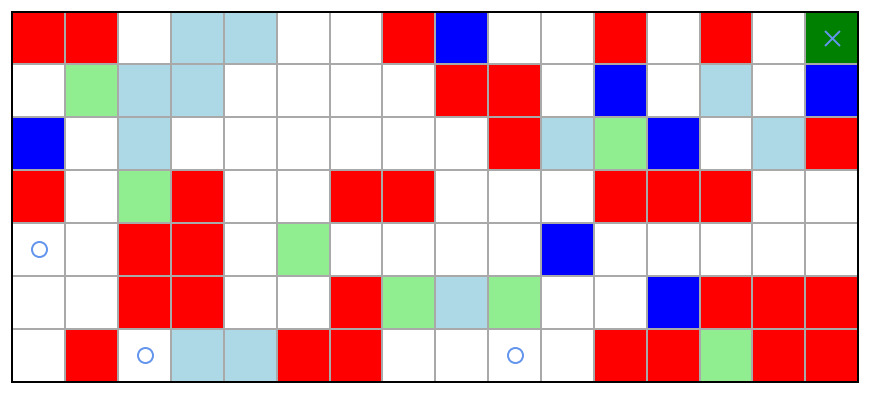

In [ ]:
# Create a gridworld
mdp2 = GridWorld(
    tile_array=[
        "xx.bb..xc..x.x.g",
        ".abb....xx.c.b.c",
        "c.b......xbac.bx",
        "x.ax..xx...xxx..",
        "s.xx.a....c.....",
        "..xx..xaba..cxxx",
        ".xsbbxx..s.xxaxx",
    ],
    feature_rewards={
        'g': 10,
        'x': -500,
        'c': -5,
        '.': 0,
        'a': 0,
        'b': 0,
    },
    absorbing_features=('g'),
    initial_features=('s'),
    discount_rate=discount_rate,
)
featurecolors = {
    'g': 'green',
    'x': 'red',
    'c': 'blue',
    '.': 'white',
    'a': 'lightgreen',
    'b': 'lightblue'
}
mdp2.plot(featurecolors=featurecolors)


In [ ]:
expert_erpi_params2 = dict(
    transition_matrix=torch.tensor(mdp2.transition_matrix),
    reward_matrix=torch.tensor(mdp2.reward_matrix),
    discount_rate=torch.tensor(mdp2.discount_rate),
    # the lower this is, the more optimal the policy
    entropy_weight=torch.tensor([entropy_weight]),
    n_planning_iters=10,
    policy_prior=None,
    initial_policy=None,
    check_convergence=True,
    force_nonzero_probabilities=True,
)

# Max Entropy IRL expert policy
expert_erpi2 = entropy_regularized_policy_iteration(
    **expert_erpi_params2
)

expert_policy2 = TabularPolicy.from_matrix(
    states=mdp2.state_list,
    actions=mdp2.action_list,
    policy_matrix=expert_erpi2.policy.detach().numpy()
)


In [ ]:
def featurizer2(state, action, next_state):
  feature_name = mdp2.location_features.get(next_state, 's')
  if feature_name in 's':
    return {}
  return {feature_name: 1}


def fixed_reward2(state, action, next_state):
  return mdp2.step_cost


In [ ]:
construal_alg2 = ConstruedLikelihoodIRL(mdp2, featurizer2, fixed_reward2, batch_size=batch_size, epochs=epochs, lr=lr, momentum=momentum, entropy_weight=entropy_weight, weight_decay=weight_decay)
max_alg2 = MaxLikelihoodIRL(mdp2, featurizer2, fixed_reward2, batch_size=batch_size, epochs=epochs, lr=lr, momentum=momentum, entropy_weight=entropy_weight, weight_decay=weight_decay)

# compute construed policy from learned weights
construal_feat_reward_matrix2 = torch.einsum(
    "sanf,f->san",
    construal_alg2.get_feature_matrix(),
    construal_learned_weights
)

construal_reward_matrix2 = construal_feat_reward_matrix2 + construal_alg2.get_fixed_reward_matrix()
terminal_index = mdp2.state_index.get(
    frozendict({'x': -1, 'y': -1}))
construal_reward_matrix2[:, :, terminal_index] = 0

construal_erpi_params = dict(
    transition_matrix=torch.tensor(mdp2.transition_matrix),
    reward_matrix=construal_reward_matrix2,
    discount_rate=torch.tensor(mdp2.discount_rate),
    entropy_weight=torch.tensor([entropy_weight]),
    n_planning_iters=10,
    policy_prior=None,
    initial_policy=None,
    check_convergence=True,
    force_nonzero_probabilities=True,
)

# compute regular policy from learned weights
max_feat_reward_matrix2 = torch.einsum(
    "sanf,f->san",
    max_alg2.get_feature_matrix(),
    max_learned_weights
)

max_reward_matrix2 = max_feat_reward_matrix2 + max_alg2.get_fixed_reward_matrix()
max_reward_matrix2[:, :, terminal_index] = 0

max_erpi_params = dict(
    transition_matrix=torch.tensor(mdp2.transition_matrix),
    reward_matrix=max_reward_matrix2,
    discount_rate=torch.tensor(mdp2.discount_rate),
    entropy_weight=torch.tensor([entropy_weight]),
    n_planning_iters=10,
    policy_prior=None,
    initial_policy=None,
    check_convergence=True,
    force_nonzero_probabilities=True,
)


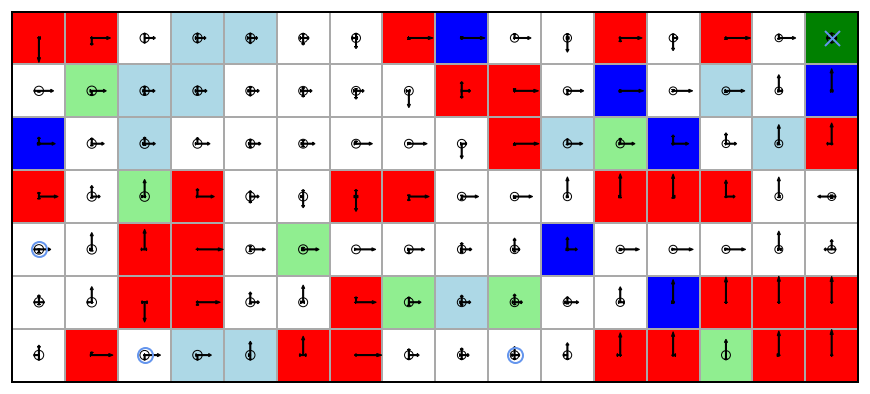

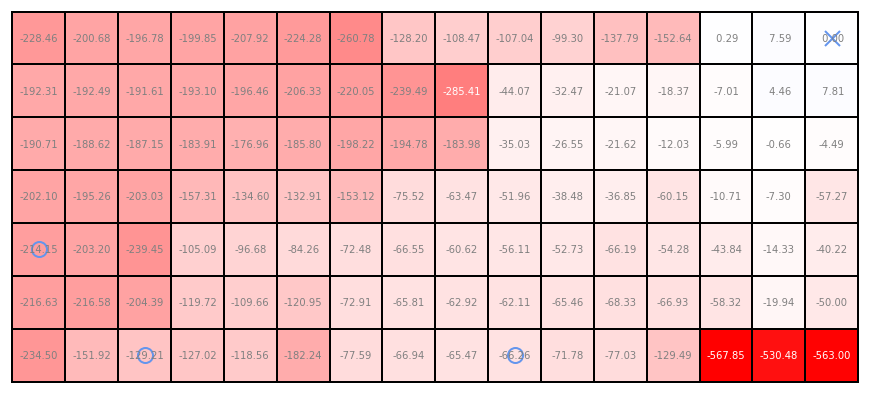

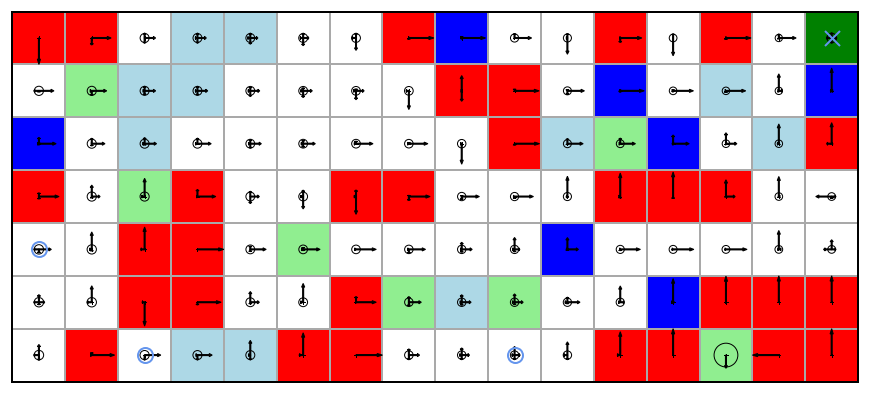

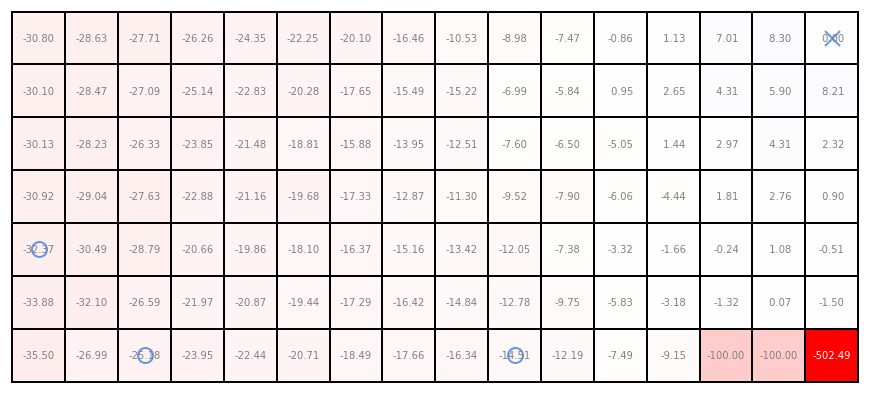

In [ ]:
construal_erpi2 = entropy_regularized_policy_iteration(**construal_erpi_params)
construal_policy2 = TabularPolicy.from_matrix(
    states=mdp2.state_list,
    actions=mdp2.action_list,
    policy_matrix=construal_erpi2.policy.detach().numpy()
)

max_erpi2 = entropy_regularized_policy_iteration(**max_erpi_params)
max_policy2 = TabularPolicy.from_matrix(
    states=mdp2.state_list,
    actions=mdp2.action_list,
    policy_matrix=max_erpi2.policy.detach().numpy()
)

mdp2.plot(featurecolors=featurecolors).plot_policy(construal_policy2)
mdp2.plot().plot_state_map(construal_policy2.evaluate_on(mdp2).V)

mdp2.plot(featurecolors=featurecolors).plot_policy(expert_policy2)
mdp2.plot().plot_state_map(expert_policy2.evaluate_on(mdp2).V)

mdp2.plot(featurecolors=featurecolors).plot_policy(max_policy2)
mdp2.plot().plot_state_map(max_policy2.evaluate_on(mdp2).V)

In [ ]:
print(f"Construal policy initial value on novel GW: {construal_policy2.evaluate_on(mdp2).initial_value}")
print(f"Expert policy initial value on novel GW: {expert_policy2.evaluate_on(mdp2).initial_value}")
print(f"Max likelihood policy initial value on novel GW: {max_policy2.evaluate_on(mdp2).initial_value}")

Learned policy's initial value: -136.53886738110597
Expert's policy initial value: -24.02009777995624
